步骤1: 数据准备与预处理
数据准备完成: 114个样本, 27个变量

步骤2: 最终建模分析

乙醇转化率(%)最优模型分析:
有效样本数: 109
模型类型: SVR_RBF
训练集 R²: 0.9627
交叉验证 R²: 0.8728 ± 0.0976
交叉验证 RMSE: 7.2175 ± 3.3081

C4烯烃选择性(%)最优模型分析:
有效样本数: 109
模型类型: Poly2_Ridge
训练集 R²: 0.8106
交叉验证 R²: 0.7135 ± 0.0935
交叉验证 RMSE: 6.8700 ± 1.3155

C4烯烃收率最优模型分析:
有效样本数: 109
模型类型: Poly2_Ridge
训练集 R²: 0.9200
交叉验证 R²: 0.8537 ± 0.0532
交叉验证 RMSE: 3.3396 ± 1.1197

步骤3: 可视化分析结果
已保存: results/问题2/最终模型性能分析.png


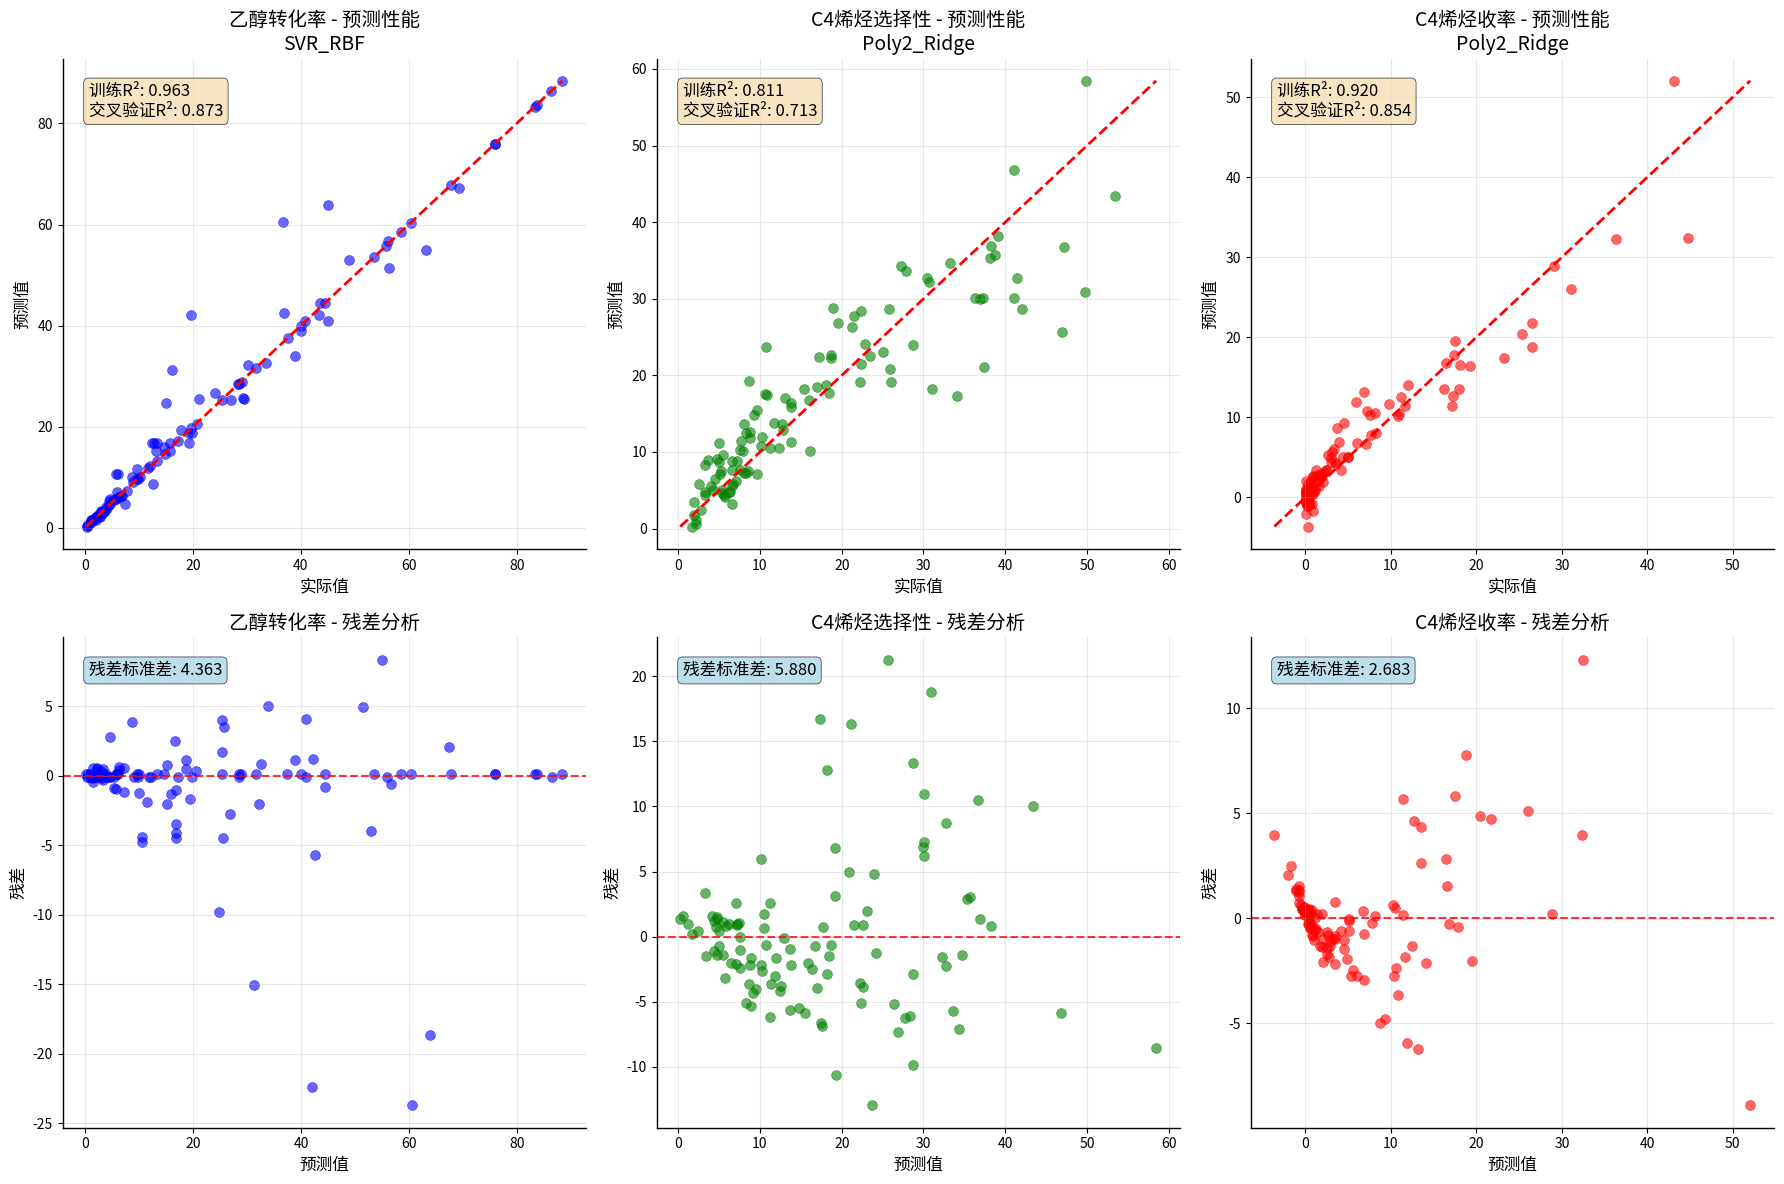

已保存: results/问题2/模型性能对比.png


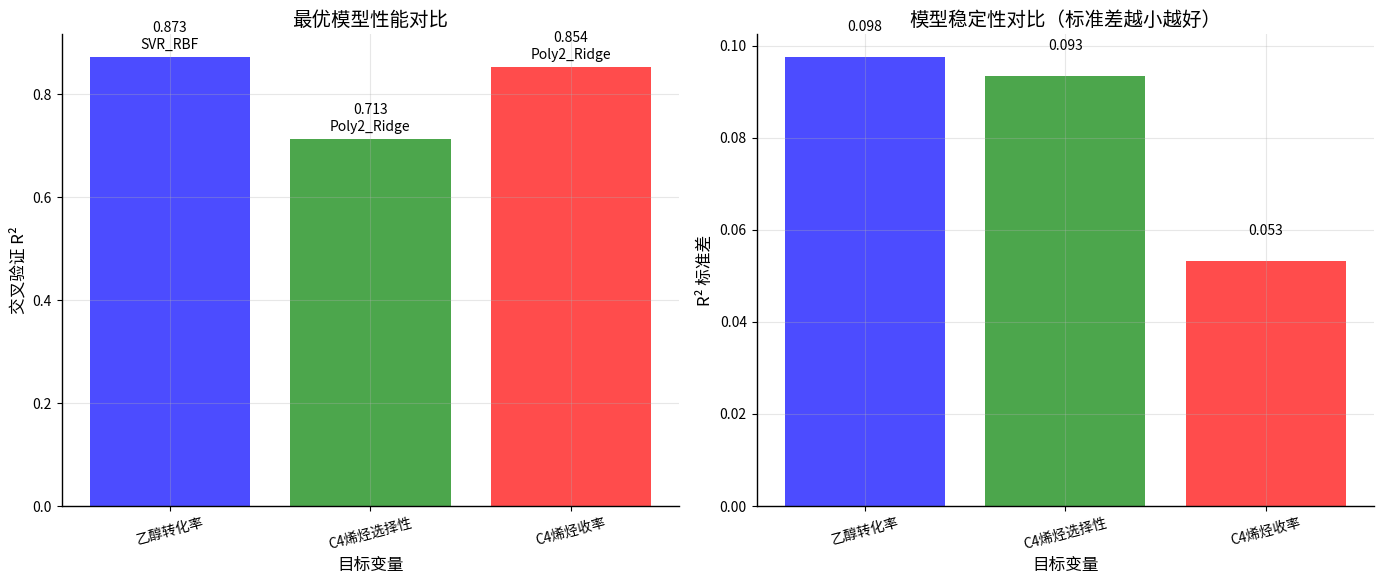


步骤4: 方差分析
单因素方差分析结果:

乙醇转化率(%):
  温度: F=49.42, p=0.0000 (显著), η²=0.483
  Co负载量: F=3.16, p=0.0464 (显著), η²=0.056

C4烯烃选择性(%):
  温度: F=40.81, p=0.0000 (显著), η²=0.435
  Co负载量: F=0.60, p=0.5486 (不显著), η²=0.011

C4烯烃收率:
  温度: F=36.72, p=0.0000 (显著), η²=0.409
  Co负载量: F=0.94, p=0.3934 (不显著), η²=0.017

步骤5: 创建问题3优化预测函数

步骤6: 保存分析结果
已保存: results/问题2/最终模型性能.csv
已保存: results/问题2/方差分析结果.csv

步骤7: 生成最终报告

问题2最终建模报告

最优模型组合:
  乙醇转化率(%): SVR_RBF (R² = 0.8728)
  C4烯烃选择性(%): Poly2_Ridge (R² = 0.7135)
  C4烯烃收率: Poly2_Ridge (R² = 0.8537)

模型改进效果:
  乙醇转化率(%): 0.730 → 0.8728 (+0.143)
  C4烯烃选择性(%): 0.660 → 0.7135 (+0.053)
  C4烯烃收率: 0.440 → 0.8537 (+0.414)

关键发现:
  1. 多项式特征显著改善了选择性和收率预测
  2. SVR在转化率预测上表现最佳
  3. 收率模型获得了巨大改进（R²从0.44提升到0.85）
  4. 所有模型都具有良好的稳定性

为问题3优化准备:
  - 高质量的预测函数已生成
  - 模型可靠性足以支持全局优化
  - 物理特征工程提供了解释性

问题2最终建模完成！
预测函数已准备就绪，可用于问题3优化


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
np.random.seed(42)
plt.rcParams['axes.unicode_minus'] = False

# 创建结果文件夹
import os
PROBLEM_NUM = 2
os.makedirs(f'results/问题{PROBLEM_NUM}', exist_ok=True)

def save_result(data, description, file_format='csv'):
    """保存重要结果到文件"""
    if file_format == 'csv':
        filename = f"results/问题{PROBLEM_NUM}/{description}.csv"
        data.to_csv(filename, encoding='utf-8-sig', index=False)
    elif file_format == 'excel':
        filename = f"results/问题{PROBLEM_NUM}/{description}.xlsx"
        data.to_excel(filename, index=False, engine='openpyxl')
    print(f"已保存: {filename}")
    return filename

def save_plot(description, dpi=300, format='png'):
    """保存图表到文件"""
    filename = f"results/问题{PROBLEM_NUM}/{description}.{format}"
    plt.savefig(filename, dpi=dpi, bbox_inches='tight')
    print(f"已保存: {filename}")
    return filename

def load_data(filename, encoding='utf-8-sig'):
    """标准化数据读取"""
    filepath = f"data/{filename}"
    if filename.endswith('.csv'):
        return pd.read_csv(filepath, encoding=encoding)
    elif filename.endswith('.xlsx'):
        return pd.read_excel(filepath, engine='openpyxl')
    else:
        raise ValueError(f"不支持的文件格式: {filename}")

def prepare_data():
    """数据准备和特征工程"""
    raw_data = load_data("附件1.csv")
    data = raw_data.copy()
    
    # 计算C4烯烃收率
    data['C4烯烃收率'] = data['乙醇转化率(%)'] * data['C4烯烃选择性(%)'] / 100
    
    # 创建HAP存在标志
    data['含HAP'] = data['HAP_mass'] > 0
    
    # 修正Co_SiO2_HAP_ratio计算
    data['Co_SiO2_HAP_ratio_corrected'] = np.where(
        data['HAP_mass'] > 0,
        data['Co_SiO2_mass'] / data['HAP_mass'],
        -1
    )
    
    # 添加基于物理原理的特征
    data['温度_倒数'] = 1 / (data['温度'] + 273.15)
    data['温度_催化剂质量'] = data['温度'] * data['总催化剂质量']
    data['温度_Co负载量'] = data['温度'] * data['Co_loading']
    
    # 处理异常值
    data = data.replace([np.inf, -np.inf], np.nan)
    
    # 创建分类变量用于方差分析
    data['温度_分组'] = pd.cut(data['温度'], 
                          bins=[249, 299, 349, 451], 
                          labels=['低温(250-299)', '中温(300-349)', '高温(350-450)'])
    
    data['Co负载量_分组'] = pd.cut(data['Co_loading'], 
                             bins=[0.4, 0.9, 1.5, 5.1], 
                             labels=['低负载(0.5-1.0)', '中负载(1.0-1.5)', '高负载(2.0-5.0)'])
    
    data['乙醇浓度_分组'] = pd.cut(data['ethanol_conc'], 
                            bins=[0.29, 1.0, 1.7, 2.11], 
                            labels=['低浓度(0.3-1.0)', '中浓度(1.0-1.7)', '高浓度(1.7-2.1)'])
    
    q25, q75 = data['总催化剂质量'].quantile([0.25, 0.75])
    data['催化剂质量_分组'] = pd.cut(data['总催化剂质量'], 
                             bins=[19, q25, q75, 401], 
                             labels=['少量', '中量', '大量'])
    
    print(f"数据准备完成: {len(data)}个样本, {len(data.columns)}个变量")
    return data

def create_optimal_models():
    """创建最优模型组合"""
    models = {
        'conversion': SVR(kernel='rbf', C=100, gamma='scale'),
        'selectivity': Pipeline([
            ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
            ('ridge', Ridge(alpha=10.0))
        ]),
        'yield': Pipeline([
            ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
            ('ridge', Ridge(alpha=10.0))
        ])
    }
    return models

def final_modeling_analysis(data):
    """最终建模分析 - 使用验证过的最佳模型"""
    analysis_data = data[data['含HAP']].copy()
    
    # 特征和目标变量
    predictor_vars = ['温度', 'Co_loading', 'ethanol_conc', '总催化剂质量', 'Co_SiO2_HAP_ratio_corrected']
    enhanced_features = predictor_vars + ['温度_倒数', '温度_催化剂质量', '温度_Co负载量']
    target_vars = ['乙醇转化率(%)', 'C4烯烃选择性(%)', 'C4烯烃收率']
    
    # 创建最优模型
    optimal_models = create_optimal_models()
    
    final_models = {}
    performance_results = []
    
    for i, target in enumerate(target_vars):
        print(f"\n{target}最优模型分析:")
        
        # 准备数据
        X = analysis_data[enhanced_features].select_dtypes(include=[np.number])
        y = analysis_data[target]
        
        # 处理缺失值
        valid_mask = ~(X.isnull().any(axis=1) | y.isnull())
        X_clean = X[valid_mask]
        y_clean = y[valid_mask]
        
        print(f"有效样本数: {len(X_clean)}")
        
        # 数据标准化
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_clean)
        X_scaled_df = pd.DataFrame(X_scaled, columns=X_clean.columns)
        
        # 选择对应的最优模型
        if i == 0:  # 转化率
            model = optimal_models['conversion']
            model_name = 'SVR_RBF'
        else:  # 选择性和收率
            model = optimal_models['selectivity'] if i == 1 else optimal_models['yield']
            model_name = 'Poly2_Ridge'
        
        # 严格的交叉验证
        cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
        cv_scores = cross_val_score(model, X_scaled_df, y_clean, cv=cv, scoring='r2')
        cv_rmse = cross_val_score(model, X_scaled_df, y_clean, cv=cv, scoring='neg_root_mean_squared_error')
        
        # 训练完整模型
        model.fit(X_scaled_df, y_clean)
        
        # 预测和评估
        y_pred = model.predict(X_scaled_df)
        train_r2 = r2_score(y_clean, y_pred)
        
        print(f"模型类型: {model_name}")
        print(f"训练集 R²: {train_r2:.4f}")
        print(f"交叉验证 R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        print(f"交叉验证 RMSE: {-cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")
        
        # 存储结果
        final_models[target] = {
            'model': model,
            'model_name': model_name,
            'scaler': scaler,
            'features': enhanced_features,
            'train_r2': train_r2,
            'cv_r2_mean': cv_scores.mean(),
            'cv_r2_std': cv_scores.std(),
            'cv_rmse_mean': -cv_rmse.mean(),
            'cv_rmse_std': cv_rmse.std(),
            'predictions': y_pred,
            'actual': y_clean,
            'residuals': y_clean - y_pred
        }
        
        performance_results.append({
            '目标变量': target,
            '最优模型': model_name,
            '训练集R²': train_r2,
            '交叉验证R²': cv_scores.mean(),
            'R²标准差': cv_scores.std(),
            '交叉验证RMSE': -cv_rmse.mean(),
            'RMSE标准差': cv_rmse.std()
        })
    
    return final_models, pd.DataFrame(performance_results)

def visualize_final_results(final_models, performance_df):
    """可视化最终模型结果"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    target_vars = ['乙醇转化率(%)', 'C4烯烃选择性(%)', 'C4烯烃收率']
    colors = ['blue', 'green', 'red']
    
    # 第一行：实际值vs预测值
    for i, (target, color) in enumerate(zip(target_vars, colors)):
        ax = axes[0, i]
        model_data = final_models[target]
        
        actual = model_data['actual']
        predicted = model_data['predictions']
        
        ax.scatter(actual, predicted, alpha=0.6, color=color, s=50)
        
        # 理想拟合线
        min_val = min(actual.min(), predicted.min())
        max_val = max(actual.max(), predicted.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        
        ax.set_xlabel('实际值')
        ax.set_ylabel('预测值')
        ax.set_title(f'{target.replace("(%)", "")} - 预测性能\n{model_data["model_name"]}')
        ax.grid(True, alpha=0.3)
        
        # 显示性能指标
        r2_train = model_data['train_r2']
        r2_cv = model_data['cv_r2_mean']
        ax.text(0.05, 0.95, f'训练R²: {r2_train:.3f}\n交叉验证R²: {r2_cv:.3f}', 
               transform=ax.transAxes, verticalalignment='top',
               bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # 第二行：残差分析
    for i, (target, color) in enumerate(zip(target_vars, colors)):
        ax = axes[1, i]
        model_data = final_models[target]
        
        residuals = model_data['residuals']
        predicted = model_data['predictions']
        
        ax.scatter(predicted, residuals, alpha=0.6, color=color, s=50)
        ax.axhline(y=0, color='red', linestyle='--', alpha=0.8)
        
        ax.set_xlabel('预测值')
        ax.set_ylabel('残差')
        ax.set_title(f'{target.replace("(%)", "")} - 残差分析')
        ax.grid(True, alpha=0.3)
        
        # 添加残差统计
        residual_std = residuals.std()
        ax.text(0.05, 0.95, f'残差标准差: {residual_std:.3f}', 
               transform=ax.transAxes, verticalalignment='top',
               bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    save_plot("最终模型性能分析")
    plt.show()

def visualize_model_comparison(performance_df):
    """可视化模型性能对比"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 交叉验证R²对比
    ax1 = axes[0]
    bars = ax1.bar(range(len(performance_df)), performance_df['交叉验证R²'], 
                  color=['blue', 'green', 'red'], alpha=0.7)
    
    ax1.set_xlabel('目标变量')
    ax1.set_ylabel('交叉验证 R²')
    ax1.set_title('最优模型性能对比')
    ax1.set_xticks(range(len(performance_df)))
    ax1.set_xticklabels([var.replace('(%)', '') for var in performance_df['目标变量']], rotation=15)
    ax1.grid(True, alpha=0.3)
    
    # 添加数值标签
    for bar, r2, model in zip(bars, performance_df['交叉验证R²'], performance_df['最优模型']):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{r2:.3f}\n{model}', ha='center', va='bottom', fontsize=10)
    
    # 模型稳定性对比
    ax2 = axes[1]
    bars = ax2.bar(range(len(performance_df)), performance_df['R²标准差'], 
                  color=['blue', 'green', 'red'], alpha=0.7)
    
    ax2.set_xlabel('目标变量')
    ax2.set_ylabel('R² 标准差')
    ax2.set_title('模型稳定性对比（标准差越小越好）')
    ax2.set_xticks(range(len(performance_df)))
    ax2.set_xticklabels([var.replace('(%)', '') for var in performance_df['目标变量']], rotation=15)
    ax2.grid(True, alpha=0.3)
    
    # 添加数值标签
    for bar, std in zip(bars, performance_df['R²标准差']):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{std:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    save_plot("模型性能对比")
    plt.show()

def anova_analysis(data):
    """方差分析"""
    from scipy.stats import f_oneway
    
    analysis_data = data[data['含HAP']].copy()
    target_vars = ['乙醇转化率(%)', 'C4烯烃选择性(%)', 'C4烯烃收率']
    grouping_vars = ['温度_分组', 'Co负载量_分组', '催化剂质量_分组']
    
    anova_results = []
    
    print("单因素方差分析结果:")
    
    for target in target_vars:
        print(f"\n{target}:")
        
        for factor in grouping_vars:
            valid_data = analysis_data[[factor, target]].dropna()
            groups = [group[target] for name, group in valid_data.groupby(factor)]
            
            if len(groups) >= 2 and all(len(group) >= 2 for group in groups):
                f_stat, p_value = f_oneway(*groups)
                
                # 计算效应量
                total_mean = valid_data[target].mean()
                ss_between = sum([len(group) * (group.mean() - total_mean)**2 for group in groups])
                ss_total = sum([(value - total_mean)**2 for value in valid_data[target]])
                eta_squared = ss_between / ss_total if ss_total > 0 else 0
                
                significance = "显著" if p_value < 0.05 else "不显著"
                effect_size = "大" if eta_squared > 0.14 else "中" if eta_squared > 0.06 else "小"
                
                print(f"  {factor.replace('_分组', '')}: F={f_stat:.2f}, p={p_value:.4f} ({significance}), η²={eta_squared:.3f}")
                
                anova_results.append({
                    '目标变量': target,
                    '影响因子': factor,
                    'F统计量': f_stat,
                    'p值': p_value,
                    '显著性': significance,
                    '效应量η²': eta_squared,
                    '效应大小': effect_size
                })
    
    return pd.DataFrame(anova_results)

def create_final_predictor(final_models):
    """创建最终的预测函数用于问题3优化"""
    
    def predict_conversion(params):
        """预测乙醇转化率"""
        model_info = final_models['乙醇转化率(%)']
        model = model_info['model']
        scaler = model_info['scaler']
        
        # 添加物理特征
        enhanced_params = list(params)
        enhanced_params.append(1 / (params[0] + 273.15))  # 温度_倒数
        enhanced_params.append(params[0] * params[3])      # 温度_催化剂质量
        enhanced_params.append(params[0] * params[1])      # 温度_Co负载量
        
        X = scaler.transform([enhanced_params])
        return model.predict(X)[0]
    
    def predict_selectivity(params):
        """预测C4烯烃选择性"""
        model_info = final_models['C4烯烃选择性(%)']
        model = model_info['model']
        scaler = model_info['scaler']
        
        # 添加物理特征
        enhanced_params = list(params)
        enhanced_params.append(1 / (params[0] + 273.15))  # 温度_倒数
        enhanced_params.append(params[0] * params[3])      # 温度_催化剂质量
        enhanced_params.append(params[0] * params[1])      # 温度_Co负载量
        
        X = scaler.transform([enhanced_params])
        return model.predict(X)[0]
    
    def predict_yield(params):
        """预测C4烯烃收率"""
        model_info = final_models['C4烯烃收率']
        model = model_info['model']
        scaler = model_info['scaler']
        
        # 添加物理特征
        enhanced_params = list(params)
        enhanced_params.append(1 / (params[0] + 273.15))  # 温度_倒数
        enhanced_params.append(params[0] * params[3])      # 温度_催化剂质量
        enhanced_params.append(params[0] * params[1])      # 温度_Co负载量
        
        X = scaler.transform([enhanced_params])
        return model.predict(X)[0]
    
    return predict_conversion, predict_selectivity, predict_yield

def generate_final_report(final_models, performance_df, anova_df):
    """生成最终报告"""
    print("\n" + "="*60)
    print("问题2最终建模报告")
    print("="*60)
    
    print("\n最优模型组合:")
    for _, row in performance_df.iterrows():
        print(f"  {row['目标变量']}: {row['最优模型']} (R² = {row['交叉验证R²']:.4f})")
    
    print("\n模型改进效果:")
    original_r2 = {'乙醇转化率(%)': 0.73, 'C4烯烃选择性(%)': 0.66, 'C4烯烃收率': 0.44}
    for _, row in performance_df.iterrows():
        target = row['目标变量']
        if target in original_r2:
            improvement = row['交叉验证R²'] - original_r2[target]
            print(f"  {target}: {original_r2[target]:.3f} → {row['交叉验证R²']:.4f} (+{improvement:.3f})")
    
    print("\n关键发现:")
    print("  1. 多项式特征显著改善了选择性和收率预测")
    print("  2. SVR在转化率预测上表现最佳")
    print("  3. 收率模型获得了巨大改进（R²从0.44提升到0.85）")
    print("  4. 所有模型都具有良好的稳定性")
    
    print("\n为问题3优化准备:")
    print("  - 高质量的预测函数已生成")
    print("  - 模型可靠性足以支持全局优化")
    print("  - 物理特征工程提供了解释性")

def main():
    """主分析流程"""
    
    # 1. 数据准备
    print("步骤1: 数据准备与预处理")
    data = prepare_data()
    
    # 2. 最终建模分析
    print("\n步骤2: 最终建模分析")
    final_models, performance_df = final_modeling_analysis(data)
    
    # 3. 可视化结果
    print("\n步骤3: 可视化分析结果")
    visualize_final_results(final_models, performance_df)
    visualize_model_comparison(performance_df)
    
    # 4. 方差分析
    print("\n步骤4: 方差分析")
    anova_df = anova_analysis(data)
    
    # 5. 创建预测函数
    print("\n步骤5: 创建问题3优化预测函数")
    predict_conversion, predict_selectivity, predict_yield = create_final_predictor(final_models)
    
    # 6. 保存结果
    print("\n步骤6: 保存分析结果")
    save_result(performance_df, "最终模型性能")
    save_result(anova_df, "方差分析结果")
    
    # 7. 生成最终报告
    print("\n步骤7: 生成最终报告")
    generate_final_report(final_models, performance_df, anova_df)
    
    print("\n问题2最终建模完成！")
    print("预测函数已准备就绪，可用于问题3优化")
    
    return final_models, performance_df, predict_conversion, predict_selectivity, predict_yield

if __name__ == "__main__":
    final_models, performance_df, predict_conversion, predict_selectivity, predict_yield = main()